In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from six.moves import urllib

In [2]:
import tensorflow as tf

In [3]:
train_path = tf.keras.utils.get_file('titanic_train.csv',
                                'https://storage.googleapis.com/tf-datasets/titanic/train.csv',
                                cache_dir='./')

eval_path = tf.keras.utils.get_file('titanic_eval.csv', 
                                    'https://storage.googleapis.com/tf-datasets/titanic/eval.csv',
                                    cache_dir='./')

In [4]:
dftrain = pd.read_csv(train_path)
dfeval = pd.read_csv(eval_path)

In [5]:
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [6]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [7]:
dfeval.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,male,54.0,0,0,51.8625,First,E,Southampton,y
2,female,58.0,0,0,26.5500,First,C,Southampton,y
3,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,male,34.0,0,0,13.0000,Second,D,Southampton,y


In [8]:
dftrain.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,627.0,29.631308,12.511818,0.75,23.0000,28.0000,35.0000,80.0000
n_siblings_spouses,627.0,0.545455,1.151090,0.00,0.0000,0.0000,1.0000,8.0000
parch,627.0,0.379585,0.792999,0.00,0.0000,0.0000,0.0000,5.0000
fare,627.0,34.385399,54.597730,0.00,7.8958,15.0458,31.3875,512.3292


In [9]:
dftrain.shape, dfeval.shape

((627, 9), (264, 9))

<AxesSubplot:>

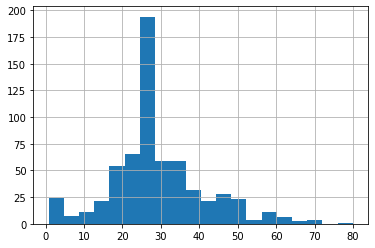

In [10]:
dftrain.age.hist(bins=20)

<AxesSubplot:>

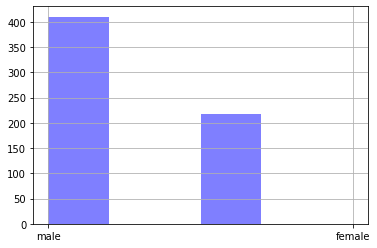

In [11]:
dftrain.sex.hist(color='blue', alpha=0.5, width=0.2, bins=2)

<AxesSubplot:>

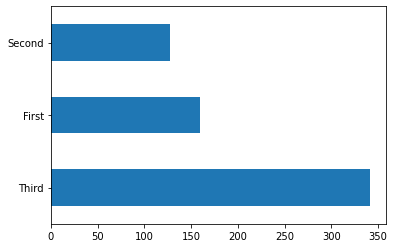

In [12]:
dftrain['class'].value_counts().plot(kind='barh')

In [13]:
pd.concat([dftrain, y_train], axis=1)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone,survived
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n,0
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n,1
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y,1
3,female,35.0,1,0,53.1000,First,C,Southampton,n,1
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y,0
...,...,...,...,...,...,...,...,...,...,...
622,male,28.0,0,0,10.5000,Second,unknown,Southampton,y,0
623,male,25.0,0,0,7.0500,Third,unknown,Southampton,y,0
624,female,19.0,0,0,30.0000,First,B,Southampton,y,1
625,female,28.0,1,2,23.4500,Third,unknown,Southampton,n,0


Text(0.5, 0, '% survive')

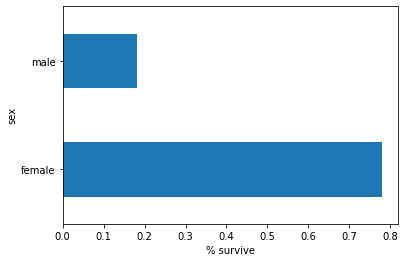

In [14]:
# 将目标列重新添加回 df
full_dftrain = pd.concat([dftrain, y_train], axis=1)
full_dftrain.groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

## Feature Engineering
确定哪些特征可能在训练模型方面非常有用，然后将日志文件及其他来源的原始数据转换为所需的特征。
feature columns:
* base feature columns from raw feature dict (原始特征)
* derived（派生、合成） feature columns from over one or multiple base columns （一般为组合特征 feature cross，笛卡尔积），特征组合有助于表达非线性关系。

### Base Feature Columns

In [15]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # 列出每个分类的值
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [16]:
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

## Input Function (create dataset)

In [17]:
def make_input_fn(data_df, label_series, num_epochs=10, shuffle=True, batch_size=32):
    def input_fn():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_series))
        if shuffle:
            ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_fn

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval)

测试一下 input_function

In [18]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['class'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Third' b'First' b'Third' b'First' b'Third' b'Third' b'Third' b'Second'
 b'Third' b'Third']

A batch of Labels: [0 1 1 1 0 0 1 1 1 0]


## Train Model with Estimator
我们已经设置好了 feature columns （base feature columns）
下面通过 estimator 训练

In [19]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/84/00xxzv8x4qgdx0bmh22wvhs40000gn/T/tmp1wqjlyqx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are 

In [20]:
result = linear_est.evaluate(eval_input_fn)
print(result)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-03T15:24:23Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/84/00xxzv8x4qgdx0bmh22wvhs40000gn/T/tmp1wqjlyqx/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.78241s
INFO:tensorflow:Finished evaluation at 2020-12-03-15:24:24
INFO:tensorflow:Saving dict for glob

### Derived Feature Columns
我们引入派生类的 feature columns，重新做特征工程。  
上面的训练结果看，我们的准确度在 75%。我们可以看出单独使用每个基本功能的列可能不足以解释数据。例如如果只仅针对“性别=“男性”和性别=“女性”学习单个模型权重，则不会捕获所有年龄-性别组合。  
为了学习不同特征组和对模型的影响，我们可以将 cross feature columns 添加到 model 上。
甚至，可以在 cross feature columns 之前，对 age 进行分桶。

In [21]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

In [22]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)
print(result)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/84/00xxzv8x4qgdx0bmh22wvhs40000gn/T/tmpm97wi9xt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in f

## predictions with model trained

In [23]:
pred_dicts = list(linear_est.predict(eval_input_fn))
pred_dicts[0]

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/84/00xxzv8x4qgdx0bmh22wvhs40000gn/T/tmpm97wi9xt/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'logits': array([-2.8688922], dtype=float32),
 'logistic': array([0.05371293], dtype=float32),
 'probabilities': array([0.9462871 , 0.05371293], dtype=float32),
 'class_ids': array([0]),
 'classes': array([b'0'], dtype=object),
 'all_class_ids': array([0, 1], dtype=int32),
 'all_classes': array([b'0', b'1'], dtype=object)}

<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

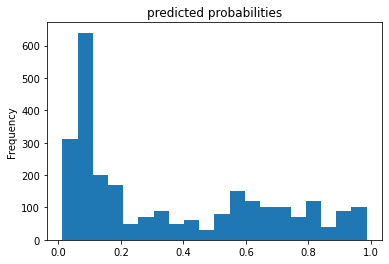

In [24]:
# 在测试集上统计能存活的概率分布
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities')